In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget
matplotlib.rc('font', size=18)
import uncertainties as unc
import scipy.special as ss

from tqdm.notebook import tqdm

import sys
sys.path.append('../')
import general_purpose.utilities as ut
import general_purpose.uplotlib as uplt

from importlib import reload

import reconstruct as rec


In [12]:
# folder = './__test__/k__4--nens__999--T__10'
# folder = './__test__/0--k__0--nens__999--T__10'
# folder = './__test__/rv--k__4--nens__999--T__10'
# folder = './__test__/rv--k__4--nens__20--T__10'
# folder = './__test__/0--k__4--nens__100--T__10'
# folder = './__test__/c--k__0--nens__999--T__10'
# folder = './__test__/c--k__0--nens__100--T__10'
# folder = './__test__/f1--k__4--nens__999--T__10'
# folder = './__test__/c0--k__0--nens__999--T__10'
folder = './__test__/chk1--k__4--nens__1000--T__10'
rec_dict = ut.json2dict(f'{folder}/reconstructed.json')

In [20]:
reload(rec)

<module 'reconstruct' from '/media/alessandro/OS/Users/ale57/Documents/0. Lyon/WORK/REA-Veros/demo/reconstruct.py'>

In [52]:
rec_dict = rec.reconstruct(f'{folder}/i0019')

DONE


In [13]:
rec_trajs = {}

for rname, r in tqdm(rec_dict['members'].items()):
    traj = []
    for subfolder,e in zip(rec_dict['folders'], r['ancestry']):
        traj.append(np.load(f'{folder}/{subfolder}/{e}-traj.npy'))
    traj = np.concatenate(traj)

    rec_trajs[rname] = traj

observables = {r: traj[-1,1] for r,traj in rec_trajs.items()}

  0%|          | 0/1000 [00:00<?, ?it/s]

In [60]:
observables = {r: np.load(f'{folder}/i0019/e{i+1:03d}-traj.npy')[-1,1] for i,r in enumerate(observables)}

In [4]:
## get the killed trajectories

nens = len(rec_dict['members'])
enss = set([f'e{i+1:0{len(str(nens))}d}' for i in range(nens)])

killed_trajs = []
for i,f in tqdm(enumerate(rec_dict['folders'])):
    kens = enss - set([r['ancestry'][i] for r in rec_dict['members'].values()])
    killed_trajs.append({ke: np.load(f'{folder}/{f}/{ke}-traj.npy') for ke in kens})

0it [00:00, ?it/s]

## Plot trajectories

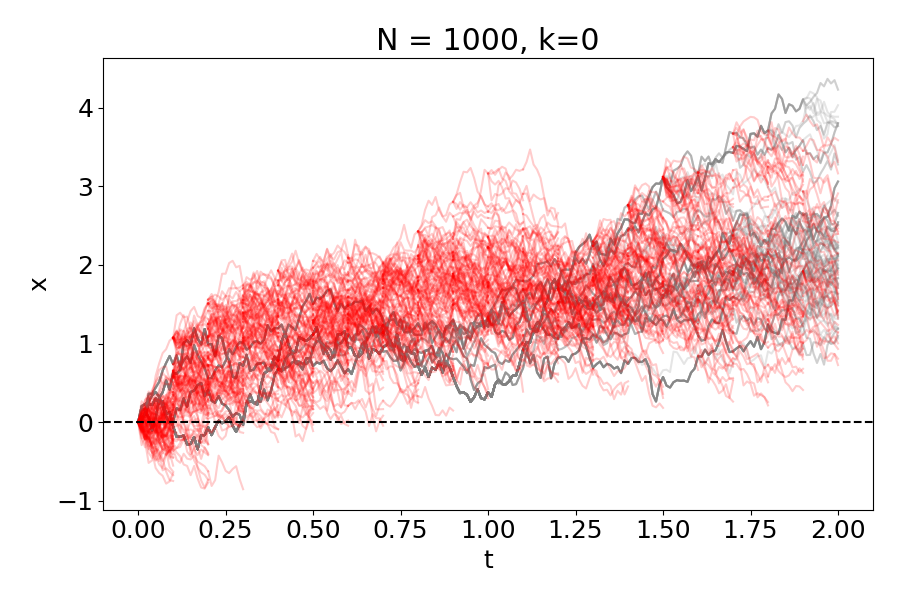

In [8]:
plt.close(1)
fig, ax = plt.subplots(num=1, figsize=(9,6))

for traj in rec_trajs.values():
    plt.plot(traj[:,0], traj[:,1], color='gray', alpha=0.2)
    
for seg in killed_trajs:
    for traj in seg.values():
        plt.plot(traj[:,0], traj[:,1], color='red', alpha=0.2)
    
plt.axhline(0, color='black', linestyle='dashed')

plt.xlabel('t')
plt.ylabel('x')
plt.title('N = 1000, k=0')

fig.tight_layout()

In [21]:
plt.close('all')

In [73]:
np.min(list(observables.values()))

1.0618594036131523

In [32]:
rec_dict['independent_parents']

[44,
 46,
 48,
 49,
 51,
 52,
 57,
 58,
 64,
 71,
 77,
 82,
 98,
 113,
 134,
 164,
 206,
 269,
 343,
 533]

## Compute expectations

In [9]:
def f(x, a):
    return float(x > a)

def expectation(func, **kwargs):
    _f = np.array([func(x, **kwargs) for x in observables.values()])
    # print(np.mean(_f))
    _w = np.array([r['weight'] for r in rec_dict['members'].values()])
    # _w = np.exp(-np.array([r['cum_log_escore'] for r in rec_dict['members'].values()]))
    # _n = np.exp(rec_dict['cum_log_norm_factor'])

    mean = np.mean(_f*_w)
    std = np.sqrt(np.mean(_f*_w**2)/len(_w))

    return unc.ufloat(mean,std)

In [39]:
np.min(list(observables.values()))

0.30721723465552814

In [61]:
expectation(f, a=2)

0.4694694694694695


0.0014738696775923035+/-0.0001743876179864498

## Theoretical probability of overcoming threshold

In [5]:
lam = 1
sig = 1
def ou_var(t):
    return sig**2/(2*lam)*(1 - np.exp(-2*lam*t))

cum_gaus = lambda x: 0.5*(1 + ss.erf(x/np.sqrt(2)))

overcoming_prob = lambda x,v: cum_gaus(-x/np.sqrt(v))

In [7]:
t = rec_trajs['r0001'][-1,0]
v = ou_var(t)

In [14]:
a = np.linspace(0,4,101)

e = np.array([expectation(f, a=_a) for _a in a])
e_th = overcoming_prob(a,v)

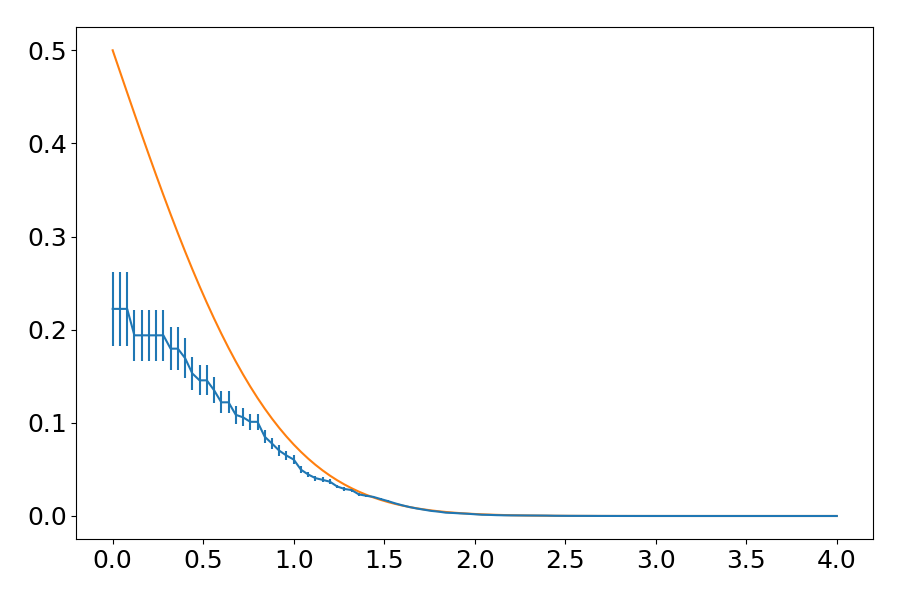

In [15]:
plt.close(2)
fig,ax = plt.subplots(figsize=(9,6))

uplt.plot(a,e)
plt.plot(a, e_th)
# plt.plot(a,uplt.std_dev(e)/uplt.nominal_value(e))
# plt.plot(a, uplt.nominal_value(e)/e_th - 1)

fig.tight_layout()

In [72]:
uplt.plot(a,e)
# plt.plot(a,uplt.std_dev(e)/uplt.nominal_value(e))

<ErrorbarContainer object of 3 artists>